In [120]:
import json
import re
import string
import random
from itertools import islice
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
from spacy.tokens import Span, Doc
from spacy.tokenizer import Tokenizer
from spacy import displacy
from tqdm import tqdm
from cytoolz import groupby
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from seqeval.metrics import f1_score, precision_score, recall_score

from daseg import SwdaDataset, Call, FunctionalSegment, TransformerModel
from daseg.data import to_transformers_ner_dataset

%load_ext autoreload
%autoreload 2

torch.set_num_interop_threads(4)
torch.set_num_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
dataset = SwdaDataset.from_path('deps/swda/swda')

transcript 1155


In [96]:
call_ids = dataset.call_ids
calls = dataset.calls
call = dataset.calls[0]
call[:10]

[FunctionalSegment(text="So I've been concerned about crime lately.", dialog_act='Statement-non-opinion', speaker='A', is_continuation=False),
 FunctionalSegment(text='Uh-huh.', dialog_act='Acknowledge (Backchannel)', speaker='B', is_continuation=False),
 FunctionalSegment(text="Uh, it's really scary to listen to the news every night and --", dialog_act='Statement-opinion', speaker='A', is_continuation=False),
 FunctionalSegment(text='Uh-huh.', dialog_act='Acknowledge (Backchannel)', speaker='B', is_continuation=False),
 FunctionalSegment(text='to hear about all the problems.', dialog_act='Statement-opinion', speaker='A', is_continuation=True),
 FunctionalSegment(text='I wondered if you were taking any special precautions in your neighborhood?', dialog_act='Declarative Yes-No-Question', speaker='A', is_continuation=False),
 FunctionalSegment(text='Well, I, I think we have a neighborhood watch.', dialog_act='Affirmative non-yes answers', speaker='B', is_continuation=False),
 FunctionalS

In [135]:
texts_by_act = dataset.acts_with_examples()

In [136]:
len(texts_by_act.keys()), texts_by_act.keys()

(46,
 dict_keys(['3rd-party-talk', 'Acknowledge (Backchannel)', 'Action-directive', 'Affirmative non-yes answers', 'Agree/Accept', 'Answer dispreferred', 'Apology', 'Appreciation', 'Backchannel in question form', 'Collaborative Completion', 'Conventional-closing', 'Conventional-opening', 'Declarative Wh-Question', 'Declarative Yes-No-Question', 'Dispreferred answers', 'Downplayer', 'Exclamation', 'Hedge', 'Hold before answer/agreement', 'Maybe/Accept-part', 'Negative non-no answers', 'No answers', 'Non-verbal', 'Offers, Options, Commits', 'Open-Question', 'Or-Clause', 'Or-question', 'Other', 'Other answers', 'Quotation', 'Reject', 'Repeat-phrase', 'Response Acknowledgement', 'Rhetorical-Questions', 'Self-talk', 'Signal-non-understanding', 'Statement expanding y/n answer', 'Statement-non-opinion', 'Statement-opinion', 'Summarize/reformulate', 'Tag-Question', 'Thanking', 'Uninterpretable', 'Wh-Question', 'Yes answers', 'Yes-No-Question']))

In [137]:
acts = set(texts_by_act.keys())

In [138]:
original_acts = set(Path('/Users/pzelasko/jhu/da/swda-dialog-act-list').read_text().split('\n')[:-1])  # empty line

In [139]:
len(original_acts)

43

In [140]:
acts - original_acts

{'Answer dispreferred',
 'Exclamation',
 'Or-question',
 'Statement expanding y/n answer'}

In [141]:
len(acts)

46

In [142]:
original_acts - acts

{'Abandoned or Turn-Exit'}

In [143]:
len(original_acts & acts)

42

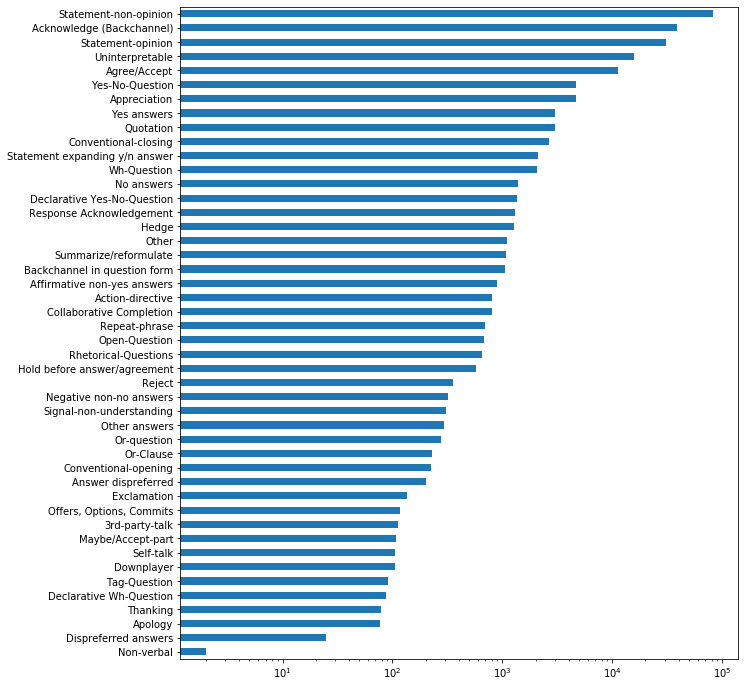

In [147]:
pd.Series({act: len(texts) for act, texts in texts_by_act.items()}).sort_values().plot.barh(figsize=(10, 12), logx=True)

In [154]:
texts_by_act['Hedge']

("And  I don't know,",
 "And  so I don't know.",
 "And I don't know",
 "And I don't know",
 "And I don't know about your part of the country,",
 "And I don't know if it would be helpful or not,",
 "And I don't know,",
 "And I don't know,",
 "And I don't know, uh, if bigger company companies do,",
 "And I don't know.",
 "And I don't know.",
 "And I don't, you know, -",
 "And I just don't know, sir,",
 "And I'm not sure how much that holds true anymore,",
 "And I, I don't know",
 "And I, I don't know,",
 "And he, I don't know, just, -",
 "And it's  not for me to say that they're not.",
 "And so it's like, I don't know. It does.",
 "And then I don't know how, you know, in terms of when you all do your federal,",
 "And then, uh, but I don't know,",
 "And then, um, I don't know",
 "And,  I don't know,",
 "And, I don't know,",
 "And, I don't know,",
 "And, I don't know,",
 "And, I don't know.",
 "And, and I don't know.",
 "And, so. I don't know,",
 "And, uh,  I don't know .",
 "And, uh,  I d

## Number of turns distribution

In [ ]:
sum(map(len, texts_by_act.values()))

In [ ]:
pd.Series([len(call) for call in calls]).hist()

## Word length distribution

In [ ]:
special_symbols = dataset.special_symbols()
len(special_symbols)

In [ ]:
words_len_dist = pd.Series([sum(len(u.split()) for u, _, _, _ in call) for call in calls])

In [ ]:
words_len_dist.hist()

In [ ]:
to_transformers_ner_dataset(calls[1073], special_symbols)[:20]

In [ ]:
if False:
    for split_name, split_dataset in dataset.train_dev_test_split().items():
        split_dataset.dump_for_transformers_ner(f'deps/transformers/examples/ner/{split_name}.txt.tmp')
else:
    print("DATASETS NOT WRITTEN TO DISK")

# Visualize

In [ ]:
call[:20]

In [ ]:
call.render(max_turns=20)

# Train the model / Predict

Refer to `run_da.sh` for this purpose. 

# Read model predictions

In [ ]:
#preds_path = '/home/pzelasko/transformers/examples/ner/swda-xlmroberta-kosher-split-t43/test_predictions.txt'
preds_path = '/home/pzelasko/daseg/deps/transformers/examples/ner/xlnet-v1/test_predictions.txt'
calls = SwdaDataset.from_transformers_predictions(preds_path)

## Render model predictions

In [ ]:
idx = 7

In [ ]:
calls.calls[idx].render(max_turns=None)

# Inference

In [115]:
eval_dset = dataset.train_dev_test_split()['test']

In [119]:
#model_dir = 'deps/transformers/examples/ner/xlnet-v1/'
model_dir = '/Users/pzelasko/jhu/da/xlnet-v1/'

In [120]:
from daseg import TransformerModel
model = TransformerModel(model_dir)

In [121]:
results = model.predict(eval_dset, batch_size=4)

Predicting dialog acts: 100%|██████████| 19/19 [06:38<00:00, 21.00s/it]


KeyboardInterrupt: 

In [ ]:
results.keys()

In [ ]:
for x in 'accuracy f1 precision recall'.split():
    print(results[x], results_crf[x])

print(classification_report(results['labels'], results['predictions']))

In [ ]:
results['dataset'].calls[0].render()